In [ ]:
import yfinance as yf
import pandas as pd
from functools import lru_cache
from pathlib import Path


# ETFs de Regiones y Sectores
REGIONES = ["SPLG", "EWC", "IEUR", "EEM", "EWJ"]
SECTORES = ["XLC","XLY","XLP","XLE","XLF","XLV","XLI",
            "XLB","XLRE","XLK","XLU"]


# Carpeta de salida
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)  # Crear carpeta si no existe


# Descargar precios ajustados
@lru_cache(maxsize=10)
def _download_prices(tickers: tuple, start="2020-01-01") -> pd.DataFrame:
    raw = yf.download(list(tickers), start=start, auto_adjust=True)

    if raw.empty:
        raise ValueError(f"Error: No se pudieron descargar datos para {tickers}")

    # MultiIndex (varios tickers)
    if isinstance(raw.columns, pd.MultiIndex):
        df = raw["Close"].copy() if "Close" in raw.columns.levels[0] else raw.iloc[:, :len(tickers)].copy()
    else:
        df = raw.iloc[:, 0].to_frame(name=tickers[0])

    return df


# Limpiar datos
def _clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.dropna(how="all", axis=1)
    df = df.dropna(how="any")
    return df


# Cargar precios
def load_prices(universe="regiones", start="2020-01-01") -> pd.DataFrame:
    if universe == "regiones":
        tickers = tuple(REGIONES)
    elif universe == "sectores":
        tickers = tuple(SECTORES)
    else:
        if isinstance(universe, str):
            tickers = (universe,)
        elif isinstance(universe, list):
            tickers = tuple(universe)
        else:
            raise ValueError("Universe inválido. Usa 'regiones', 'sectores' o lista de tickers.")

    df = _download_prices(tickers, start=start)
    df = _clean_data(df)
    return df


# Cargar rendimientos
def load_returns(universe="regiones", start="2020-01-01") -> pd.DataFrame:
    prices = load_prices(universe, start=start)
    returns = prices.pct_change().dropna()
    return returns


# Guardar cada ETF en CSV individual
def save_returns_to_csv(returns_df: pd.DataFrame, universe: str):
    # Carpeta para este universo
    dir_path = OUTPUT_DIR / universe
    dir_path.mkdir(exist_ok=True)

    for col in returns_df.columns:
        file_path = dir_path / f"{col}_returns.csv"
        returns_df[[col]].to_csv(file_path, index=True)
        print(f"✅ Guardado: {file_path}")


# Verificación rápida de funcionalidad
if __name__ == "__main__":
    for universe in ["regiones", "sectores"]:
        returns_df = load_returns(universe)
        print(f"\nPrimeras filas de rendimientos ({universe}):")
        print(returns_df.head())

        save_returns_to_csv(returns_df, universe)

[*********************100%***********************]  5 of 5 completed



Primeras filas de rendimientos (regiones):
Ticker           EEM       EWC       EWJ      IEUR      SPLG
Date                                                        
2020-01-03 -0.018567 -0.005003 -0.011026 -0.011346 -0.006292
2020-01-06 -0.002448  0.005028  0.003547  0.001812  0.003166
2020-01-07 -0.000669  0.001001  0.001683 -0.004019 -0.002630
2020-01-08  0.005805 -0.001000  0.000168  0.001816  0.005274
2020-01-09  0.006659  0.001668  0.007056  0.001208  0.007345
✅ Guardado: output/regiones/EEM_returns.csv
✅ Guardado: output/regiones/EWC_returns.csv
✅ Guardado: output/regiones/EWJ_returns.csv
✅ Guardado: output/regiones/IEUR_returns.csv
✅ Guardado: output/regiones/SPLG_returns.csv


[*********************100%***********************]  11 of 11 completed


Primeras filas de rendimientos (sectores):
Ticker           XLB       XLC       XLE       XLF       XLI       XLK  \
Date                                                                     
2020-01-03 -0.016145 -0.006450 -0.002971 -0.010618 -0.001928 -0.011243   
2020-01-06 -0.004354  0.013355  0.007781 -0.000650  0.000362  0.002383   
2020-01-07 -0.001177  0.001281 -0.002629 -0.006508 -0.002051 -0.000432   
2020-01-08  0.003536  0.007130 -0.016471  0.006551  0.003385  0.010700   
2020-01-09  0.003691  0.005264  0.007369  0.006183  0.004217  0.011336   

Ticker           XLP      XLRE       XLU       XLV       XLY  
Date                                                          
2020-01-03 -0.001601  0.007326  0.002037 -0.008714 -0.008510  
2020-01-06  0.002084  0.000260  0.000938  0.006223  0.002781  
2020-01-07 -0.007679 -0.010906 -0.001406 -0.001963 -0.001585  
2020-01-08  0.003708  0.004988 -0.000469  0.006492  0.003016  
2020-01-09  0.007067 -0.000261  0.005479  0.004300  0.00530

# Importamos librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime, timedelta

# Add the Markowitz directory to sys.path to allow importing sf_library
sys.path.append('output/')
import sf_library as sfl

import scipy.optimize as op

ModuleNotFoundError: No module named 'sf_library'

# Selección de Tickers (Sectorial y Regional)

In [ ]:
tickers_sectorial = [
    'XLK',  # Tecnología
    'XLF',   # Finanzas
    'XLV',   # Salud
    'XLP',   # Consumo básico
    'XLY',   # Consumo discrecional
    'XLE',  # Energía
    'XLI',   # Industrial
    'XLC',  # Comunicaciones
    'XLB',   # Materiales
    'XLU',  # Servicios públicos
    'XLRE' # Bienes raíces
]


In [ ]:
# Descargamos la información de los tickers regionales (No están en el MarketData del repositorio)
tickers_regional = ['SPLG', #Replica el SyP500
                    'EWC',  #ETF canadience
                    'IEUR', #ETF europo
                    'EEM',  #ETF mercados emergente
                    'EWJ'   #ETF japonés
                    ]

# La función descargar_tickers guardará los archivos en la carpeta
sfl.descargar_tickers(tickers_regional, carpeta='SF_2026_1/Markowitz/MarketData/')


Descargando datos de SPLG...


/content/SF_2026_1/Markowitz/sf_library.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tic, start=start, end=end, progress=False)


Descargando datos de EWC...


/content/SF_2026_1/Markowitz/sf_library.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tic, start=start, end=end, progress=False)


Descargando datos de IEUR...


/content/SF_2026_1/Markowitz/sf_library.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tic, start=start, end=end, progress=False)


Descargando datos de EEM...


/content/SF_2026_1/Markowitz/sf_library.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tic, start=start, end=end, progress=False)


Descargando datos de EWJ...


/content/SF_2026_1/Markowitz/sf_library.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tic, start=start, end=end, progress=False)


Función para calculo de portafolios

In [ ]:
def matrices_activos(tickers):
    """
    Carga, sincroniza y procesa los rendimientos diarios de una lista de tickers.
    Calcula la matriz de varianza-covarianza, la matriz de correlación y el vector de mínima varianza.

    Parámetros:
    - tickers (list): Una lista de símbolos de activos (strings).

    Retorna:
    - df_filtrado_5_años (pd.DataFrame): DataFrame con los rendimientos sincronizados y filtrados por los últimos 5 años.
    - retornos_sin_fecha (pd.DataFrame): DataFrame con los rendimientos sin la columna 'date'.
    - mtx_var_covar (np.ndarray): Matriz de varianza-covarianza de los retornos filtrados.
    - mtx_correl (pd.DataFrame): Matriz de correlación de los retornos filtrados.
    - min_var_vector (np.ndarray): Vector de pesos para la cartera de mínima varianza.
    """

    data_dir = "SF_2026_1/Markowitz/MarketData/"
    rendimientos_tickers = []

    for ticker in tickers:
        t = sfl.daily_return(ticker, data_dir=data_dir)
        t = t[['date', 'return']].rename(columns={'return': ticker})
        rendimientos_tickers.append(t)

    df_sincronizado = rendimientos_tickers[0]
    for t_df in rendimientos_tickers[1:]:
        df_sincronizado = pd.merge(df_sincronizado, t_df, on='date', how='inner')

    df_sincronizado = df_sincronizado.dropna().sort_values('date').reset_index(drop=True)

    max_date = df_sincronizado['date'].max()
    start_date_5_years = max_date - timedelta(days=5 * 365)

    df_filtrado_5_años = df_sincronizado[(df_sincronizado['date'] >= start_date_5_years) &
                                        (df_sincronizado['date'] <= max_date)]

    retornos_sin_fecha = df_filtrado_5_años.drop(columns='date')

    mtx_var_covar = retornos_sin_fecha.cov().values
    mtx_correl = retornos_sin_fecha.corr()

    # Mínima varianza con descomposición de autovalores
    eigenvalues, eigenvectors = np.linalg.eigh(mtx_var_covar)
    min_var_vector = eigenvectors[:, 0]

    # Impresión
    print("### Matriz de Varianza-Covarianza")
    df_var_covar = pd.DataFrame(mtx_var_covar, index=tickers, columns=tickers)
    display(df_var_covar.round(6))
    print("\n### Matriz de Correlación")
    display(mtx_correl.round(4))
    print("\n### Vector de Mínima Varianza")
    series_min_var = pd.Series(min_var_vector, index=tickers)
    display(series_min_var.round(4))

    plt.figure(figsize=(8, 6))
    sns.heatmap(mtx_correl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Mapa de Calor de la Matriz de' + str(tickers)+'')
    plt.show()

    return df_filtrado_5_años, retornos_sin_fecha, mtx_var_covar, mtx_correl, min_var_vector


### Matriz de Varianza-Covarianza


,SPLG,EWC,IEUR,EEM,EWJ
SPLG,0.000113,0.000091,0.000088,0.000083,0.000083
EWC,0.000091,0.000117,0.000095,0.000088,0.000081
IEUR,0.000088,0.000095,0.000120,0.000094,0.000087
EEM,0.000083,0.000088,0.000094,0.000133,0.000083
EWJ,0.000083,0.000081,0.000087,0.000083,0.000123



### Matriz de Correlación


,SPLG,EWC,IEUR,EEM,EWJ
SPLG,1.0000,0.7901,0.7610,0.6746,0.7061
EWC,0.7901,1.0000,0.8011,0.7036,0.6807
IEUR,0.7610,0.8011,1.0000,0.7477,0.7221
EEM,0.6746,0.7036,0.7477,1.0000,0.6455
EWJ,0.7061,0.6807,0.7221,0.6455,1.0000



### Vector de Mínima Varianza


,0
SPLG,-0.3661
EWC,0.7059
IEUR,-0.5779
EEM,0.0848
EWJ,0.1627


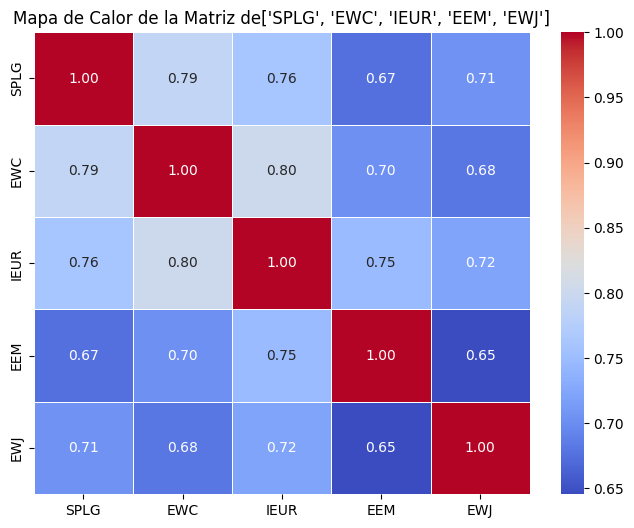

(           date      SPLG       EWC      IEUR       EEM       EWJ
 1631 2020-12-03  0.000000  0.006849  0.003165  0.011455  0.002439
 1632 2020-12-04  0.008817  0.015225  0.008872  0.010332  0.004562
 1633 2020-12-07 -0.001840  0.000638 -0.006449  0.000000 -0.014684
 1634 2020-12-08  0.002535  0.002232  0.003147  0.000393  0.002304
 1635 2020-12-09 -0.008504 -0.002545 -0.000392 -0.008649  0.007051
 ...         ...       ...       ...       ...       ...       ...
 2880 2025-11-25  0.008636  0.009990  0.017236  0.003541  0.002202
 2881 2025-11-26  0.006799  0.013382  0.009056  0.007242  0.016357
 2882 2025-11-28  0.005378  0.008612  0.006369  0.001475 -0.003003
 2883 2025-12-01 -0.004478 -0.009867 -0.004891 -0.000736 -0.005782
 2884 2025-12-02  0.001874 -0.000767  0.004192  0.000368 -0.000727
 
 [1254 rows x 6 columns],
           SPLG       EWC      IEUR       EEM       EWJ
 1631  0.000000  0.006849  0.003165  0.011455  0.002439
 1632  0.008817  0.015225  0.008872  0.010332  0.004562


In [ ]:
matrices_activos(tickers_regional)

# Markowitz

In [ ]:
#Función rendimiento y riesgo del portafolio
# =====================================================================
def portafolio_rendimiento(weights):
    #Calcula retorno y volatilidad del portafolio.

    ret = np.dot(weights, mean_returns)                # w^T μ
    vol = np.sqrt(weights @ cov_matrix @ weights.T)    # sqrt(w^T Σ w)
    return ret, vol

In [ ]:
import scipy.optimize as op

def minima_volatilidad():
    x0 = np.ones(n)/n      # Condición inicial: pesos iguales
    bounds = tuple((0,1) for _ in range(n))  # Pesos entre 0 y 1 (no short)
    restriccion = ({'type':'eq','fun':lambda w: np.sum(w)-1})  # Suma de pesos = 1

    # Minimizamos solo la volatilidad:
    # minimize( σp(w) )
    result = op.minimize(
        lambda w: portafolio_rendimiento(w)[1],
        x0, constraints=restriccion, bounds=bounds
    )
    return result.x, portafolio_rendimiento(result.x)

In [ ]:
def maximo_retorno():
    x0 = np.ones(n)/n
    bounds = tuple((0,1) for _ in range(n))
    restriccion = ({'type':'eq','fun':lambda w: np.sum(w)-1})

    # maximize(rp)  equivale a minimize(-rp)
    result = op.minimize(
        lambda w: -portafolio_rendimiento(w)[0],
        x0, constraints=restriccion, bounds=bounds
    )
    return result.x, portafolio_rendimiento(result.x)

In [ ]:
def maximo_sharpe(risk_free=0.0):
    """
    Sharpe ratio:
        S = (rp - rf) / σp
    maximize(S)  <--> minimize( -S )
    """
    x0 = np.ones(n)/n
    bounds = tuple((0,1) for _ in range(n))
    restriccion = ({'type':'eq','fun':lambda w: np.sum(w)-1})

    def neg_sharpe(w):
        r, vol = portafolio_rendimiento(w)
        return -(r - risk_free) / vol    # Negativo porque minimize() debe maximizar el Sharpe

    result = op.minimize(
        neg_sharpe, x0, constraints=restriccion, bounds=bounds
    )
    return result.x, portafolio_rendimiento(result.x)

In [ ]:
def min_varianza_retorno(retorno_deseado):

    # Punto inicial: pesos iguales
    x0 = np.ones(n) / n

    # Restricciones: suma de pesos = 1  y retorno objetivo
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},                     # suma = 1
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - retorno_deseado}  # retorno deseado
    )

    # No permitir posiciones cortas (0 a 1)
    bounds = tuple((0, 1) for _ in range(n))

    # Función objetivo: varianza
    def variance(w):
        return w @ cov_matrix @ w.T

    # Optimización
    result = op.minimize(
        variance,
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    # Retornar pesos + rendimiento y riesgo resultante
    w = result.x
    ret, vol = portafolio_rendimiento(w)

    return w, ret, vol

### Matriz de Varianza-Covarianza


,SPLG,EWC,IEUR,EEM,EWJ
SPLG,0.000113,0.000091,0.000088,0.000083,0.000083
EWC,0.000091,0.000117,0.000095,0.000088,0.000081
IEUR,0.000088,0.000095,0.000120,0.000094,0.000087
EEM,0.000083,0.000088,0.000094,0.000133,0.000083
EWJ,0.000083,0.000081,0.000087,0.000083,0.000123



### Matriz de Correlación


,SPLG,EWC,IEUR,EEM,EWJ
SPLG,1.0000,0.7901,0.7610,0.6746,0.7061
EWC,0.7901,1.0000,0.8011,0.7036,0.6807
IEUR,0.7610,0.8011,1.0000,0.7477,0.7221
EEM,0.6746,0.7036,0.7477,1.0000,0.6455
EWJ,0.7061,0.6807,0.7221,0.6455,1.0000



### Vector de Mínima Varianza


,0
SPLG,-0.3661
EWC,0.7059
IEUR,-0.5779
EEM,0.0848
EWJ,0.1627


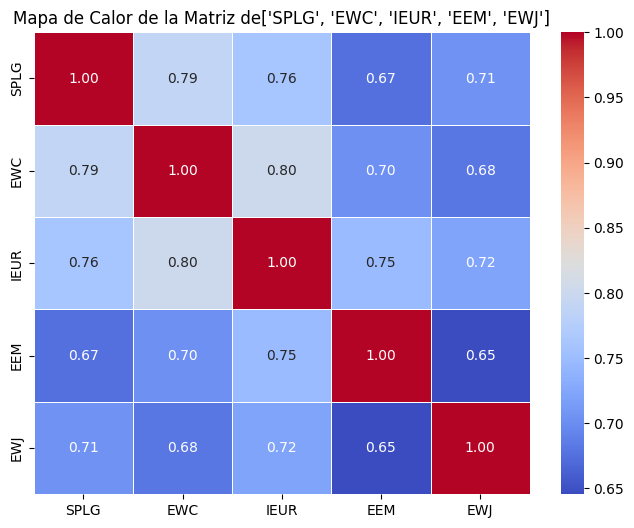


--- Portafolio de mínima volatilidad ---


,Pesos
SPLG,0.2792
EWC,0.1962
IEUR,0.0953
EEM,0.1713
EWJ,0.2579


Rendimiento: 0.1109, Volatilidad: 0.1534

--- Portafolio de máximo retorno ---


,Pesos
SPLG,1.0
EWC,0.0
IEUR,0.0
EEM,0.0
EWJ,0.0


Rendimiento: 0.1537, Volatilidad: 0.1687

--- Portafolio de máximo Sharpe ---


,Pesos
SPLG,0.7111
EWC,0.2889
IEUR,0.0000
EEM,0.0000
EWJ,0.0000


Rendimiento: 0.1502, Volatilidad: 0.1620

--- Portafolio de mínima varianza con retorno objetivo (0.05) ---


,Pesos
SPLG,0.6958
EWC,0.3042
IEUR,0.0000
EEM,0.0000
EWJ,0.0000


Rendimiento: 0.1500, Volatilidad: 0.1618


In [ ]:
df_filtrado_5_años, retornos_sin_fecha, mtx_var_covar, mtx_correl, min_var_vector = matrices_activos(tickers_regional)

#Construcción de matriz de retornos y parámetros de Markowitz
# =====================================================================
# Matriz solo de retornos
returns = retornos_sin_fecha
# Retorno promedio anual de cada activo
mean_returns = returns.mean() * 252   # Multiplicado por días de mercado
# Matriz de covarianza anualizada
cov_matrix = mtx_var_covar * 252
n = len(tickers_regional)   # Número de activos

# --- Portafolio de mínima volatilidad ---
print ("\n--- Portafolio de mínima volatilidad ---")
pesos_min_vol, (ret_min_vol, vol_min_vol) = minima_volatilidad()
display(pd.Series(pesos_min_vol, index=tickers_regional, name='Pesos').round(4))
print(f"Rendimiento: {ret_min_vol:.4f}, Volatilidad: {vol_min_vol:.4f}")

# --- Portafolio de máximo retorno ---
print ("\n--- Portafolio de máximo retorno ---")
pesos_max_ret, (ret_max_ret, vol_max_ret) = maximo_retorno()
display(pd.Series(pesos_max_ret, index=tickers_regional, name='Pesos').round(4))
print(f"Rendimiento: {ret_max_ret:.4f}, Volatilidad: {vol_max_ret:.4f}")

# --- Portafolio de máximo Sharpe ---
print ("\n--- Portafolio de máximo Sharpe ---")
pesos_max_sharpe, (ret_max_sharpe, vol_max_sharpe) = maximo_sharpe()
display(pd.Series(pesos_max_sharpe, index=tickers_regional, name='Pesos').round(4))
print(f"Rendimiento: {ret_max_sharpe:.4f}, Volatilidad: {vol_max_sharpe:.4f}")

# --- Portafolio de mínima varianza con retorno objetivo ---
print ("\n--- Portafolio de mínima varianza con retorno objetivo (0.05) ---")
pesos_min_var_obj, ret_min_var_obj, vol_min_var_obj = min_varianza_retorno(0.15)
display(pd.Series(pesos_min_var_obj, index=tickers_regional, name='Pesos').round(4))
print(f"Rendimiento: {ret_min_var_obj:.4f}, Volatilidad: {vol_min_var_obj:.4f}")